##### Job2, Part 2, Start

This is starter code for Job 2, Part 2. Most important is the definition of the Dataset object for loading, separately, the train, validation and test image sets. Students can use as much or as little of this as they wish and can modify it in anyway they'd like

In [33]:
import numpy as np
import os 
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
def is_image(fn):
    # Check if the given filename has an image file extension.
    extensions = ['.jpg', '.jpeg', '.png']
    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    full_image_paths = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image
        if (os.path.isfile(file_path) and is_image(filename)):
            # Try opening the image
            try:
                im = Image.open(file_path)
                full_image_paths.append(file_path)
                if (verbose):
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")
    print(f'Returing {len(full_image_paths)} image paths')
    return full_image_paths

folder_path = "job2_data/valid/ocean"
full_paths = find_images_in_folder(folder_path, verbose=False)

Returing 150 image paths


In [ ]:
'''
Provide a Dataset object for the five class dataset.
'''

# These are empirically determined values to optimize image intensity rescaling prior to training
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

'''
The Dataset class we write must include the __init__, __len__ and __getitem__ (subscripting) 
methods.
'''
class job2_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        '''
        Produce a list of the full image paths and class indices for all images
        in the given set (found along the path).  Record a transform to be
        applied by the __getitem__ method to each image.
        '''
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []
        for idx, nm in enumerate(class_names):
            folder_path = os.path.join(path, nm)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([transforms.Resize(new_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)
        return im, class_i
        
        
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
new_size = None # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = job2_Dataset("job2_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = job2_Dataset("job2_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset = job2_Dataset("job2_data/test", class_names, new_size=new_size, verbose=verbose)

Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths


The validation dataset has 750 images
After the shuffle the 0th image has class index 1
Image shape is (240, 360, 3)


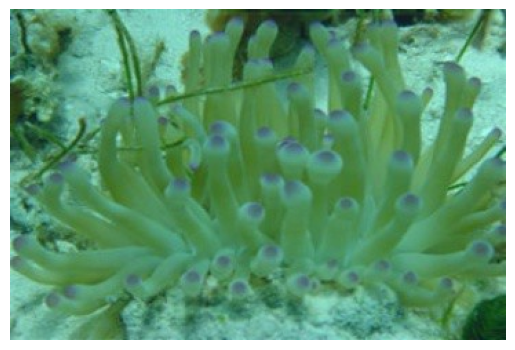

1


In [36]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

In [37]:
import numpy as np
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=5, input_size='original'):
        """
        Initialize a simple Convolutional Neural Network (CNN) for image classification.
        
        Parameters:
            num_classes (int): Number of output classes.
            input_size (str):
                'original' for original image size (240x360) or 'small' for resized images such as 64x64.
        """
        super(CNN, self).__init__()
        # First convolutional layer: converts 3-channel input to 16 channels.
        # in_channels=3 corresponds to RGB images.
        # padding = 1: Pad 1 pixel around the image to ensure that the image size remains unchanged after convolution.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Pooling layer (max pooling with kernel size 2).
        # kernel_size=2: 2×2 pooling window, reducing the size by half each time.
        # stride=2: sliding step size 2, so that the output size is reduced by half.
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: converts 16 channels to 32 channels.
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        # Determine the fully connected layer input dimension based on input size.
        if (input_size == "small"):
            # For images resized to 64x64, after two poolings the feature map size becomes 16x16.
            # 16, 16 are the height and width of the feature map.
            # 32 is the number of channels of the previous layer output (after the second convolutional layer).
            # 128 is the number of neurons in the hidden layer.
            self.fc1 = nn.Linear(32 * 16 * 16, 128)
        else:
            # For original images (240x360), after two poolings the feature map size becomes 60x90.
            self.fc1 = nn.Linear(32 * 60 * 90, 128)
        # Output layer that produces logits for each class.
        # 128-dimensional features are mapped to num_classes categories (default 5 categories).
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Define the forward pass of the CNN.
        self.conv1(x): The first layer of convolution, extracting features of 16 channels.
        F.relu(): ReLU activation function, introducing nonlinearity to prevent gradient disappearance.
        self.pool(): Maximum pooling, reducing size and improving computational efficiency.
        self.conv2(x): The second layer of convolution, extracting deeper features.
        x.view(x.size(0), -1): Flatten the 2D feature map for input into the fully connected layer.
        self.fc1(x): Fully connected layer, converted to 128-dimensional features.
        self.fc2(x): The final output layer, obtaining logits (unnormalized classification scores) of num_classes dimensions.
        
        Parameters:
            x (tensor): Input image batch.
        
        Returns:
            tensor: The output logits for each class.
        """
        x = self.pool(F.relu(self.conv1(x))) # Convolution + ReLU activation + Pooling
        x = self.pool(F.relu(self.conv2(x))) # Convolution + ReLU activation + Pooling
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = F.relu(self.fc1(x)) # Fully connected layer with ReLU
        x = self.fc2(x) # Output layer (logits)
        return x

### Training Function

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    """
    Train the CNN model and validate after each epoch.
    
    Parameters:
        model (nn.Module): The CNN model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        valid_loader (DataLoader): DataLoader for the validation dataset.
        criterion: Loss function (FE: CrossEntropyLoss).
        optimizer: Optimization algorithm (FE: Adam).
        num_epochs (int): Number of training epochs.
        device: Device to run training on (CPU or GPU).
    
    Returns:
        dict: Training history including losses and accuracies.
    """
    best_valid_accuracy = 0.0
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train() # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        # Training loop over batches
        for images, labels in train_loader:
            # Sending data to GPU/CPU
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad() # Zero the gradients, PyTorch's gradients are accumulated and must be cleared manually.
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss, criterion = nn.CrossEntropyLoss()
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            # loss.item() extracts the loss value, multiply it by images.size(0) to ensure it is the total loss of the batch.
            running_loss += loss.item() * images.size(0)
            # torch.max(outputs, 1) returns: preds, The index of the maximum value such as the class prediction.
            _, preds = torch.max(outputs, 1)
            # calculates the number of correct predictions.
            running_corrects += torch.sum(preds == labels).item()
            total_samples += images.size(0)
        
        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = running_corrects / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        
        # Validation loop
        model.eval() # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        # Disable gradient calculation (reduce memory usage)
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels).item()
                total_samples += images.size(0)
                
        epoch_valid_loss = running_loss / total_samples
        epoch_valid_acc = running_corrects / total_samples
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)
        
        # Save the best model based on validation accuracy
        if (epoch_valid_acc > best_valid_accuracy):
            best_valid_accuracy = epoch_valid_acc
            torch.save(model.state_dict(), "best_model.pth")
        
        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, "
              f"Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, "
              f"Valid Acc: {epoch_valid_acc:.4f}, Time: {end_time - start_time:.1f}s")
    
    print("\nTraining complete!")
    print(f"Best validation accuracy: {best_valid_accuracy:.4f}")
    
    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_accuracies": train_accuracies,
        "valid_accuracies": valid_accuracies
    }

### Evaluation Function

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Evaluate the trained model on the test dataset.
    
    Parameters:
        model (nn.Module): The trained CNN model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device: Device to run evaluation on (CPU or GPU).
        class_names (list): List of class names.
    
    Returns:
        dict: Evaluation results including overall accuracy, per-class accuracy, and confusion matrix.
    """
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            # Maximum value (highest value of logits), Maximum value index (FE: predicted category preds)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    overall_acc = np.mean(all_preds == all_labels)
    print(f"Overall Test Accuracy: {overall_acc:.4f}")
    
    # Compute per-class accuracy
    num_classes = len(class_names)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    for label, pred in zip(all_labels, all_preds):
        class_total[label] += 1
        if (label == pred):
            class_correct[label] += 1
    
    per_class_acc = {}
    for i in range(num_classes):
        if (class_total[i] > 0):
            acc = class_correct[i] / class_total[i]
            per_class_acc[class_names[i]] = acc
            print(f"Class {class_names[i]} Accuracy: {acc:.4f}")
        else:
            per_class_acc[class_names[i]] = None
            print(f"Class {class_names[i]} has no samples in the test set!")
    
    # Compute and display the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on Test Set')
    plt.show()
    
    return {
        "overall_accuracy": overall_acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm
    }

### Main Section For CNN Model

Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Epoch [1/10], Train Loss: 0.8750, Train Acc: 0.6866, Valid Loss: 0.6521, Valid Acc: 0.7560, Time: 94.8s
Epoch [2/10], Train Loss: 0.4754, Train Acc: 0.8360, Valid Loss: 0.5431, Valid Acc: 0.8053, Time: 88.3s
Epoch [3/10], Train Loss: 0.3386, Train Acc: 0.8889, Valid Loss: 0.4887, Valid Acc: 0.8227, Time: 90.1s
Epoch [4/10], Train Loss: 0.2558, Train Acc: 0.9226, Valid Loss: 0.5118, Valid Acc: 0.8120, Time: 90.7s
Epoch [5/10], Train Loss: 0.1618, Train Acc: 0.9531, Valid Loss: 0.5481, Valid Acc: 0.8093, Time: 93.0s
Epoch [6/10], Train Loss: 0.1070, Train Acc: 0.9734, Valid Loss: 0.5142, Valid Acc: 0.8227, Time: 91.3s
E

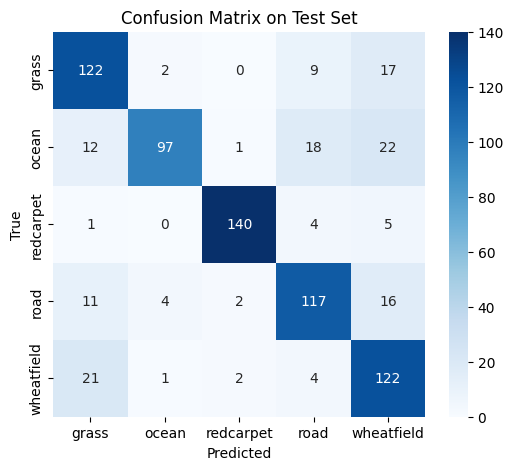

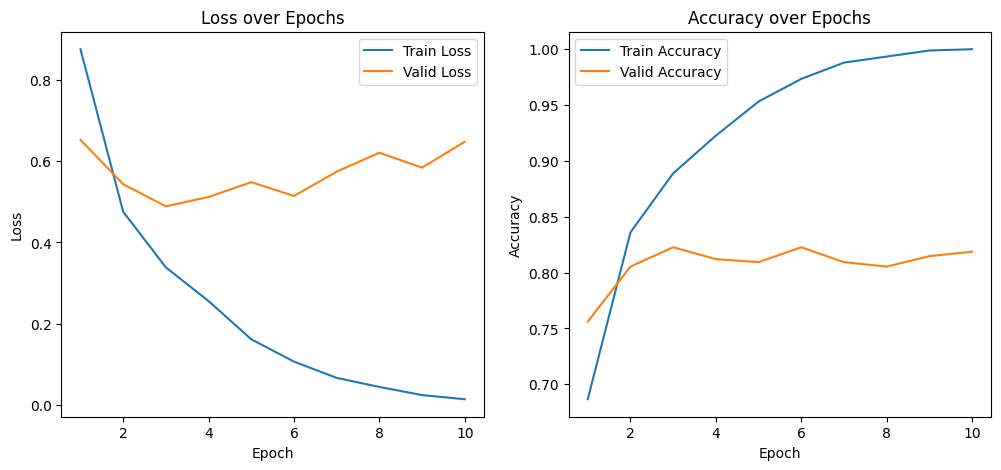

In [ ]:
# Define the five class names corresponding to the dataset folders.
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# Set the new_size parameter:
# - Set to None to use the original image size (240x360),
# - or specify a tuple like (64, 64) for resized (smaller) images.
new_size = None # Change to a tuple such as (64, 64) if resizing is desired.
verbose = False # Set to True for detailed output during dataset initialization.

# Create dataset objects for training, validation, and test sets.
train_dataset = job2_Dataset("job2_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = job2_Dataset("job2_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset  = job2_Dataset("job2_data/test", class_names, new_size=new_size, verbose=verbose)

# Create DataLoaders for each dataset.
batch_size = 16 # Adjust batch size based on available hardware.
# Set num_workers=0 to avoid multiprocessing issues.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Set the device for training (use GPU if available).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the CNN model.
# For original image size, use input_size='original'; if using resized images (FE: (64,64)), set input_size='small'.
model = CNN(num_classes=len(class_names), input_size='original')
model.to(device)

# Define the loss function and the optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set the number of training epochs.
num_epochs = 10

# Train the model and obtain the training history.
history = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

# After training, load the best model based on validation accuracy.
best_model = CNN(num_classes=len(class_names), input_size='original')
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.to(device)

# Evaluate the best model on the test dataset.
evaluation_results = evaluate_model(best_model, test_loader, device, class_names)

# Plot the training and validation loss and accuracy curves.
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_losses"], label='Train Loss')
plt.plot(epochs_range, history["valid_losses"], label='Valid Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_accuracies"], label='Train Accuracy')
plt.plot(epochs_range, history["valid_accuracies"], label='Valid Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN Model 2

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes=5, input_size='original'):
        """
        Initialize a simple Convolutional Neural Network (CNN) for image classification.
        
        Parameters:
            num_classes (int): Number of output classes.
            input_size (str): 'original' for original image size (240x360) or 
                              'small' for resized images (FE: 64x64).
        """
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        if (input_size == 'small'):
            # If images are resized to 64x64, after two poolings => (32, 16, 16)
            self.fc1 = nn.Linear(32 * 16 * 16, 128)
        else:
            # If images keep original size 240x360, after two poolings => (32, 60, 90)
            self.fc1 = nn.Linear(32 * 60 * 90, 128)
        
        # Add a dropout layer to reduce overfitting
        # Dropout (randomly discard 50% of neurons)
        # Purpose: Prevent overfitting, randomly block 50% of neurons during training.
        # Only works in training mode (model.train()), will not affect the results during inference
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Define the forward pass of the CNN.
        
        Parameters:
            x (tensor): Input image batch.
        
        Returns:
            tensor: The output logits for each class.
        """
        x = self.pool(F.relu(self.conv1(x))) # Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x))) # Convolution + ReLU + Pooling
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Dropout layer
        x = self.fc2(x) # Output layer
        return x

### Main Section For CNN Model 2

Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Epoch [1/10], Train Loss: 0.9937, Train Acc: 0.6303, Valid Loss: 0.6668, Valid Acc: 0.7640, Time: 93.7s
Epoch [2/10], Train Loss: 0.7101, Train Acc: 0.7434, Valid Loss: 0.6180, Valid Acc: 0.7960, Time: 93.3s
Epoch [3/10], Train Loss: 0.5441, Train Acc: 0.8009, Valid Loss: 0.5356, Valid Acc: 0.8200, Time: 91.5s
Epoch [4/10], Train Loss: 0.4758, Train Acc: 0.8317, Valid Loss: 0.5157, Valid Acc: 0.8187, Time: 91.8s
Epoch [5/10], Train Loss: 0.3910, Train Acc: 0.8611, Valid Loss: 0.4846, Valid Acc: 0.8267, Time: 92.9s
Epoch [6/10], Train Loss: 0.3237, Train Acc: 0.8857, Valid Loss: 0.5102, Valid Acc: 0.8267, Time: 98.3s
E

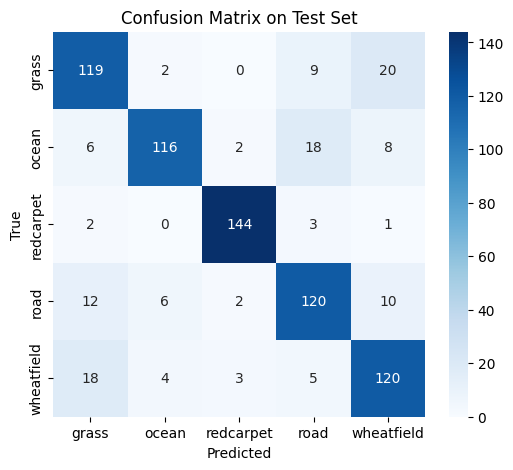

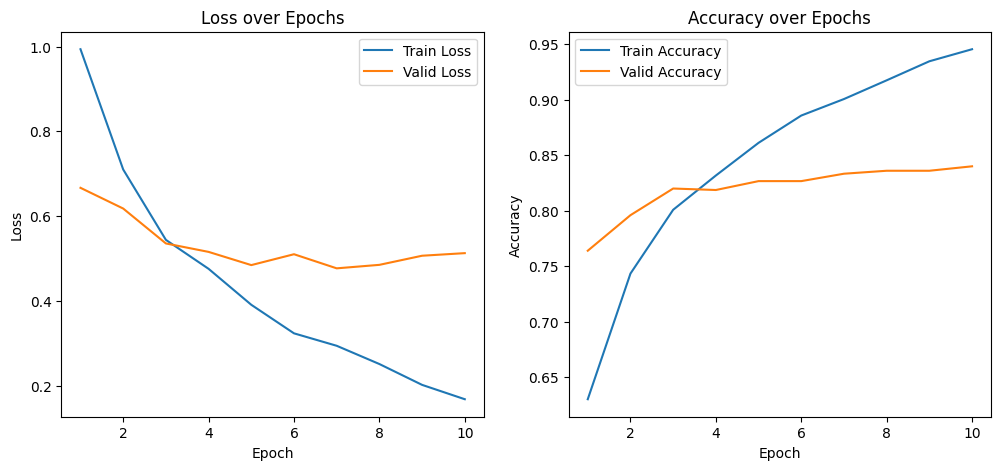

In [ ]:
# Define the five class names corresponding to the dataset folders.
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# Set the new_size parameter:
# - Set to None to use the original image size (240x360),
# - or specify a tuple like (64, 64) for resized (smaller) images.
new_size = None # Change to a tuple such as (64, 64) if resizing is desired.
verbose = False # Set to True for detailed output during dataset initialization.

# Create dataset objects for training, validation, and test sets.
# Note that we set train=True for the training dataset to enable data augmentation.
train_dataset = job2_Dataset("job2_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = job2_Dataset("job2_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset  = job2_Dataset("job2_data/test",  class_names, new_size=new_size, verbose=verbose)

# Create DataLoaders for each dataset.
batch_size = 16 # Adjust batch size based on available hardware.
# Set num_workers=0 if you have issues with multiprocessing on your system.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

# Set the device for training (use GPU if available).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the CNN model.
# For original image size, use input_size='original'; if using resized images, set input_size='small'.
model = CNN2(num_classes=len(class_names), input_size='original')
model.to(device)

# Define the loss function and the optimizer.
# Added weight_decay to reduce overfitting.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Set the number of training epochs.
num_epochs = 10

# Train the model and obtain the training history.
history = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

# After training, load the best model based on validation accuracy.
best_model = CNN2(num_classes=len(class_names), input_size='original')
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.to(device)

# Evaluate the best model on the test dataset.
evaluation_results = evaluate_model(best_model, test_loader, device, class_names)

# Plot the training and validation loss and accuracy curves.
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_losses"], label='Train Loss')
plt.plot(epochs_range, history["valid_losses"], label='Valid Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_accuracies"], label='Train Accuracy')
plt.plot(epochs_range, history["valid_accuracies"], label='Valid Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Analysis

**I have two different CNN models in the ipynb.**

**Comparison of CNN Version 1 and CNN Version 2**

In the **first version (CNN 1)**, the network achieves a best validation accuracy of around **82.27%** and a final test accuracy of **79.73%**. The training accuracy becomes extremely high (close to or reaching 100% in the final epoch), which indicates that the model is fitting the training set very strongly. However, its performance on the test set is notably lower. From the confusion matrix, we see that “ocean” in particular struggles, reaching only **64.67%** accuracy. On the other hand, “redcarpet” is recognized well at **93.33%**, likely because of its distinctive color and texture. This version of the network lacks additional regularization measures such as data augmentation, dropout, or weight decay, so it tends to overfit the training set while not generalizing as well to unseen data.

By contrast, the **second version (CNN 2)** incorporates data augmentation (random flips and rotations), dropout, and weight decay to reduce overfitting. The training accuracy in this version is somewhat lower than the first (about 94–95% by the last epoch), but the validation accuracy peaks at **84.00%**, and the final test accuracy reaches **82.53%**—a noticeable improvement over the first version. Notably, the “ocean” class improves to **77.33%** accuracy, suggesting that the added augmentation and regularization help the network handle a wider variety of ocean-like scenes. “Redcarpet” is classified with even higher accuracy (**96.00%**), indicating that CNN 2 retains strong performance on visually distinctive categories. Overall, CNN 2 balances the training and validation performance more effectively and exhibits less of the gap seen in CNN 1.

**Design Choices and Experimental Results**

The main design differences revolve around regularization techniques. CNN 2 uses data augmentation, which artificially expands the diversity of training examples by flipping and rotating images. This forces the model to learn more robust features rather than memorizing specific image layouts. Dropout further reduces overfitting by randomly “turning off” a fraction of the neurons in the fully connected layers, preventing co-adaptation. Weight decay (L2 regularization) penalizes large weights and thus also curbs overfitting. Together, these strategies help CNN 2 achieve a higher test accuracy than CNN 1. Although CNN 2’s training accuracy does not reach 100%, the validation and test accuracies are higher, which is typically a good sign of improved generalization.

**When the Classifier Works Well and When It Works Poorly**

Both CNNs excel at recognizing classes like “redcarpet,” where color and texture are quite distinctive. The “ocean” and “grass” classes are more challenging, likely because they can be confused with “road” or “wheatfield” if parts of the image contain similar backgrounds or color palettes (for instance, a sandy beach or grassy roadside). CNN 2’s improvements in “ocean” suggest that data augmentation helped the model see different variations of watery textures, thereby reducing confusion with other classes. Nevertheless, occasional misclassifications still happen when images share overlapping elements—like grass near a road or wheatfield scenes with similar shades of green and yellow.